In [124]:
import tensorflow.compat.v1 as tf 
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
%load_ext tensorboard

## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [125]:
fashion_mnist = keras.datasets.fashion_mnist

In [126]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

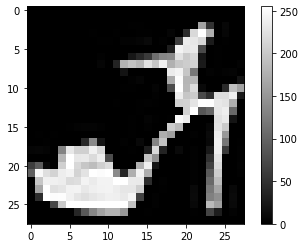

In [127]:
plt.imshow(train_images[9], cmap = 'gray')
plt.colorbar()

## Labels

In [128]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

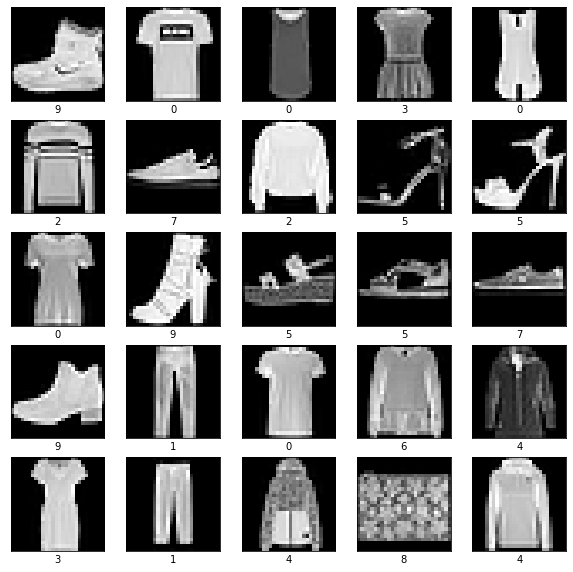

In [129]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

In [130]:
def filtrarPorLabel(imagenes, labels):
    condition = ( labels == 0 ) + ( labels == 1 ) + ( labels == 2 )
    return(imagenes[condition], labels[condition])

In [131]:
imagenes_filtradas_train, labels_filtrados_train = filtrarPorLabel(train_images, train_labels)
imagenes_filtradas_test, labels_filtrados_test = filtrarPorLabel(test_images, test_labels)
imgs = len(imagenes_filtradas_train)
filaspixeles = len(imagenes_filtradas_train[0])
colspixeles = len(imagenes_filtradas_train[0])
imgst = len(imagenes_filtradas_test)
filaspixelest = len(imagenes_filtradas_test[0])
colspixelest = len(imagenes_filtradas_test[0][0])


In [168]:
img_reshaped_tr = imagenes_filtradas_train.reshape(imgs, filaspixeles*colspixeles)
img_reshaped_te = imagenes_filtradas_test.reshape(imgst, filaspixelest*colspixelest)
labels = { 0: 'T-shirt/top' , 1: 'Trouser', 2: 'Pullover'}

def logModel(epochs, lr, x, xlabels, nlabels , filas, cols , bs , test, testlabels ):
    tf.reset_default_graph()
    x_train = tf.constant(x[:,:])
    x_train = tf.cast(x_train, tf.float32)
    y_tr = tf.one_hot(xlabels[:],3)
    y_test = tf.one_hot(testlabels[:],3)
    ws = tf.Variable(tf.truncated_normal([filas * cols, nlabels]))
    log = tf.matmul(x_train, ws)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_tr,logits=log))
    error_summary = tf.summary.scalar(name="LOSS", tensor=loss)
    grads = tf.gradients(loss, ws)
    newws =  tf.subtract(ws ,tf.multiply(lr , grads[0] ))
    updatews = tf.assign(ws, newws)
    x_traint = tf.constant(test[:,:])
    x_traint = tf.cast(x_traint, tf.float32)
    logtest = tf.nn.softmax(tf.matmul(x_traint, newws))
    accuracy = tf.reduce_all(tf.math.equal(logtest, y_test), axis = 1)
    accuracyPerc = tf.reduce_sum(tf.cast(accuracy, tf.float32))/len(test)
    acc_summary = tf.summary.scalar(name="ACCURACY", tensor=accuracyPerc)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        writer = tf.summary.FileWriter(('.graphs/graphs_'+str(lr)+str(epochs)), sess.graph)
        sess.run(init)
        for epoch in range(epochs): 
            e_summary = sess.run(error_summary)
            sess.run(updatews) 
            if epoch % 100 == 0:
                print('Epoch', epoch , 'LOSS = ', loss.eval())
                print('Epoch', epoch , 'Accuracy Percentage = ', accuracyPerc.eval())
                a_summary = sess.run(acc_summary)
                writer.add_summary(a_summary,epoch)
            
            writer.add_summary(e_summary,epoch)
        return(ws.eval())
    


# Grafo de TensorBoard
![image info](./grafo.png)
# Sin normalizacion


In [169]:
logModel(1000,0.001,img_reshaped_tr,labels_filtrados_train,3,filaspixeles,colspixeles,32,img_reshaped_te[:, :], labels_filtrados_test[:]  )

Epoch 0 LOSS =  1312.5105
Epoch 0 Accuracy Percentage =  0.62299997
Epoch 100 LOSS =  77.518906
Epoch 100 Accuracy Percentage =  0.913
Epoch 200 LOSS =  65.33121
Epoch 200 Accuracy Percentage =  0.92366666
Epoch 300 LOSS =  58.71446
Epoch 300 Accuracy Percentage =  0.928
Epoch 400 LOSS =  54.14634
Epoch 400 Accuracy Percentage =  0.92866665
Epoch 500 LOSS =  50.7727
Epoch 500 Accuracy Percentage =  0.931
Epoch 600 LOSS =  48.040096
Epoch 600 Accuracy Percentage =  0.9306667
Epoch 700 LOSS =  45.813908
Epoch 700 Accuracy Percentage =  0.9313333
Epoch 800 LOSS =  43.914494
Epoch 800 Accuracy Percentage =  0.931
Epoch 900 LOSS =  42.246895
Epoch 900 Accuracy Percentage =  0.9313333


array([[ 0.48095256, -1.0009636 ,  0.24766566],
       [ 0.8232481 , -1.4148613 ,  1.7365752 ],
       [ 0.6081534 ,  0.60292304, -1.6247611 ],
       ...,
       [ 1.3864638 ,  0.34735814,  0.47138634],
       [ 0.40759215,  0.21202444, -0.07443239],
       [ 1.3882797 , -0.8532998 , -1.2183172 ]], dtype=float32)

# Accuracy 
![image info](./accuracynonorm.png)
# Error 
![image info](./errornonorm.png)

# Con normalizacion

In [184]:
modelows = logModel(1000,0.5,img_reshaped_tr/255,labels_filtrados_train,3,filaspixeles,colspixeles,32,img_reshaped_te[:, :], labels_filtrados_test[:]  )

Epoch 0 LOSS =  5.7475376
Epoch 0 Accuracy Percentage =  0.40433332
Epoch 100 LOSS =  0.34372666
Epoch 100 Accuracy Percentage =  0.91033334
Epoch 200 LOSS =  0.27846408
Epoch 200 Accuracy Percentage =  0.91866666
Epoch 300 LOSS =  0.24529101
Epoch 300 Accuracy Percentage =  0.926
Epoch 400 LOSS =  0.22386652
Epoch 400 Accuracy Percentage =  0.92866665
Epoch 500 LOSS =  0.20843029
Epoch 500 Accuracy Percentage =  0.9306667
Epoch 600 LOSS =  0.19653504
Epoch 600 Accuracy Percentage =  0.93299997
Epoch 700 LOSS =  0.18691336
Epoch 700 Accuracy Percentage =  0.93299997
Epoch 800 LOSS =  0.17885089
Epoch 800 Accuracy Percentage =  0.9343333
Epoch 900 LOSS =  0.17191993
Epoch 900 Accuracy Percentage =  0.9343333


# Accuracy 
![image info](./accuracynorm.png)
# Error 
![image info](./errornorm.png)

In [213]:
def predecir(img,label):
    plt.figure(figsize=(10,10))
    imgpredreshaped = img.reshape( filaspixeles*colspixeles)
    logitspred = np.matmul(imgpredreshaped,modelows)
    predvals = np.exp(logitspred - np.max(logitspred))/np.sum(np.exp(logitspred-np.max(logitspred)))
    predict = labels[np.argmax(predvals)]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap='gray')
    plt.xlabel('Real Value:' +labels[label] + ' - Predicted:' + predict)
    plt.show()

# Prediccion de imagenes

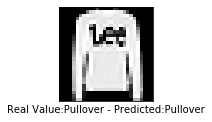

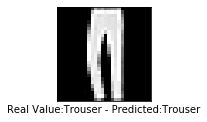

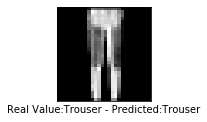

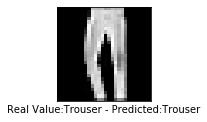

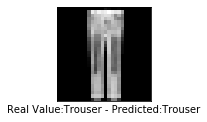

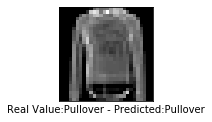

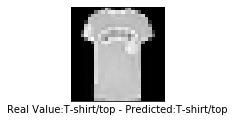

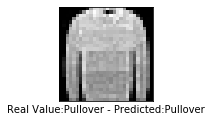

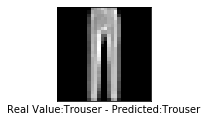

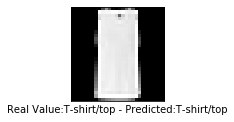

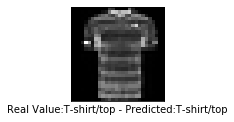

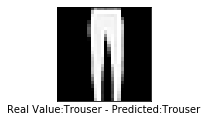

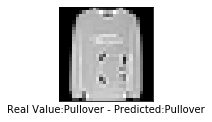

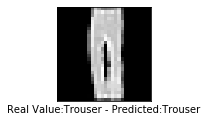

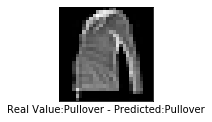

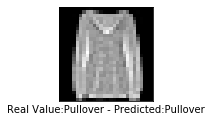

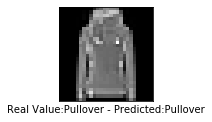

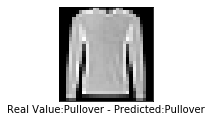

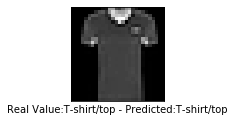

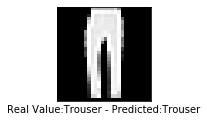

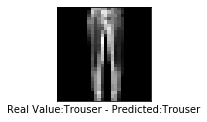

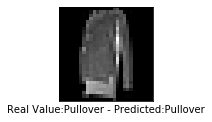

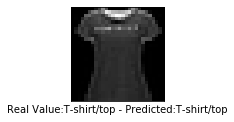

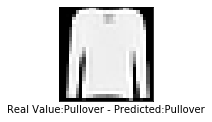

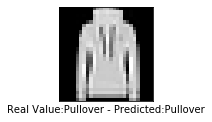

In [214]:
for i in range(25):
    predecir(imagenes_filtradas_test[i],labels_filtrados_test[i])